# Qishon - The Quarry Station
In this notebook we will be looking at Qishon - The Quarry station which is near the Qishon river and in Afula region. This notebook uses data from 2018 to 2021 with the addition of rainfall data.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd "/content/drive/My Drive/Colab Notebooks"

/content/drive/My Drive/Colab Notebooks


In [ ]:
!pip install import-ipynb
import import_ipynb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 12.9 MB/s eta 0:00:00


In [ ]:
from functions import *

importing Jupyter notebook from functions.ipynb


In [ ]:
# fix random seed for reproducibility
seed = 10
np.random.seed(seed)
tf.random.set_seed(seed)

Loading the data after preprocessing:

In [ ]:
path_flow = '/content/drive/MyDrive/FinalProjectDataScience/flow_in_hydro_stations.xlsx'
df = pd.read_excel(path_flow)

In [ ]:
df_flow = df.copy(deep=True)

In [ ]:
df_flow.head()

,gauge_id,time,flow,water_level
0,2105,1966-10-01 00:00:00,0.000,0.00
1,2105,1966-12-19 18:35:00,0.027,2.88
2,2105,1966-12-19 18:35:00,0.027,0.00
3,2105,1966-12-19 18:45:00,0.037,2.90
4,2105,1966-12-19 19:00:00,0.037,2.90


In [ ]:
path_catalog = '/content/drive/MyDrive/FinalProjectDataScience/hydro_stations_catalog.xlsx'
df_catalog = pd.read_excel(path_catalog)

In [ ]:
df_catalog.head()

,זיהוי תחנה,שם עברית,שם אנגלית,שם קודם,תאריך הקמה,שטח היקוות (קמר),X .נ.צ,Y .נ.צ,קשר עם תחנה קודמת,תחום התנקזות ראשי,סטטוס תחנה
0,1102,בצת-כביש 4,BEZET- ROAD 4,כרכרה,27/01/2015,102.0,211086.0,775565.0,NaN,בצת,לא פעילה
1,1105,בצת - ע''י אילון,BEZET - NEAR AYYALON,NaN,01/10/1949,71.0,221150.0,775650.0,NaN,בצת,לא פעילה
2,1106,בצת - ע''י חורבת כרכרה,BEZET - NEAR AYYALON,NaN,01/10/1944,71.0,220950.0,775350.0,NaN,בצת,לא פעילה
3,2105,כזיב - גשר הזיו,KEZIV - HAZIV BRIDGE,כביר,01/10/1966,130.0,210315.0,772922.0,NaN,כזיב,פעילה
4,2106,כזיב - גשר הרכבת,KEZIV - RAILWAY BRIDGE,כביר,01/10/1944,131.0,210100.0,772800.0,2105.0,כזיב,לא פעילה


# Pipeline

Our approach is to build a different LSTM model for each station.

Since running a model for each station is computationaly heavy, we will choose specific stations that are of interest, and run the model on them only.

The pipeline is:

1. Run a basic LSTM model on a specific gauge - without additional data.
2. Run an LSTM model with the addition of the rainfall data.
3. Compare between the 2 models.
4. Run hyperparameter optimization on the LSTM model with the rainfall data.
5. Run LSTM model after optimization.
6. Run a GRU model with the rainfall data.
7. Run hyperparameter optimization on the GRU model with the rainfall data.
8. Compare results between LSTM and GRU.

## Hyperparameters

In [ ]:
# Time Resolution
time_resolution = '1H'

# Number of sequences in the data per hour (depends on time resolution)
sequences_per_hour = 1

# Lead time (by hours)
l = 3

# Number of epochs
epochs = 5

# Batch size
batch_size = 64

# Number of years to train over
n_train_years = 3

# size of validation set
validation_split = 0.333

## Preprocess

In [ ]:
gauge_id = 8146
gauge_name = df_catalog[df_catalog['זיהוי תחנה'] == gauge_id]['שם אנגלית'].iloc[0]

In [ ]:
gauge_df = get_data_of_gauge(gauge_id)
gauge_df.drop(columns=['gauge_id'], inplace=True)

<ipython-input-54-2081e5c32cd2>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gauge_df.drop(columns=['gauge_id'], inplace=True)


In [ ]:
# Set 'timestamp' as the DataFrame index
gauge_df['time'] = pd.to_datetime(gauge_df['time'])

<ipython-input-55-cfd5998e3239>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gauge_df['time'] = pd.to_datetime(gauge_df['time'])


In [ ]:
gauge_df = gauge_df[(gauge_df['time'].dt.year >= START_YEAR) & (gauge_df['time'].dt.year <= END_YEAR)]

In [ ]:
gauge_df = resample_data(gauge_df, time_resolution)

In [ ]:
gauge_df

,flow,water_level
time,,
2018-01-01 00:00:00,0.170000,10.400000
2018-01-01 01:00:00,0.238000,10.420000
2018-01-01 02:00:00,0.306000,10.440000
2018-01-01 03:00:00,0.374000,10.460000
2018-01-01 04:00:00,0.380051,10.461282
...,...,...
2021-12-09 18:00:00,0.202000,10.410000
2021-12-09 19:00:00,0.202000,10.410000
2021-12-09 20:00:00,0.202000,10.410000


In [ ]:
# prepare loss function
std = gauge_df['flow'].std()
nse_star = get_nse_loss(std)

In [ ]:
# prepare nse metric
mean = gauge_df['flow'].mean()
nse_tensor = get_nse_tensor(mean)
nse_numpy = get_nse_numpy(mean)

## Choice of Lead Time

In [ ]:
nse_means = {1:0, 2:0, 3:0}
persist_nse_means = {1:0, 2:0, 3:0}
n_iter = 3

for i in range(n_iter):
  for lead_time in range(1, 4):
    # number of lag hours
    n_hours = lead_time * sequences_per_hour
    reframed, scaler = prepare_data(gauge_df, n_hours)

    # number of total features
    n_features = len(gauge_df.columns)

    # drop columns of reframed that are not for prediction
    n_cols_reframed = len(reframed.columns)
    reframed.drop(reframed.columns[n_cols_reframed-n_features+1:], axis=1, inplace=True)

    # split into train and test sets
    # n_train_hours = num_months_train * DAYS_PER_MONTH * HOURS_PER_DAY * sequences_per_hour
    n_train_hours = int(0.8 * len(gauge_df))
    train_X, train_y, test_X, test_y = split_train_and_test(reframed, n_train_hours, n_hours, n_features)

    # prepare creating model
    metrics = [persistent_nse_tensor, nse_tensor]
    create_model = build_model(train_X, nse_star, metrics, LSTM)

    # run model
    model = create_model()
    history = model.fit(train_X, train_y, epochs=epochs, batch_size=batch_size, validation_split=validation_split, verbose=2, shuffle=False)

    # make a prediction
    yhat = model.predict(test_X)
    test_X = test_X.reshape((test_X.shape[0], n_hours*n_features))

    # invert scaling for forecast
    inv_yhat = np.concatenate((yhat, test_X[:, -(n_features-1):]), axis=1)
    inv_yhat = scaler.inverse_transform(inv_yhat)
    inv_yhat = inv_yhat[:,0]

    # invert scaling for actual
    test_y = test_y.reshape((len(test_y), 1))
    inv_y = np.concatenate((test_y, test_X[:, -(n_features-1):]), axis=1)
    inv_y = scaler.inverse_transform(inv_y)
    inv_y = inv_y[:,0]

    # calculate NSE
    nse_numpy = get_nse_numpy(mean)
    nse_metric = nse_numpy(inv_y, inv_yhat)
    nse_means[lead_time] += nse_metric/n_iter

    # calculate persistNSE
    persist_nse_metric = persistent_nse_numpy(inv_y, inv_yhat)
    persist_nse_means[lead_time] += persist_nse_metric/n_iter

Epoch 1/5
288/288 - 9s - loss: 2.5814e-04 - persistent_nse_tensor: 0.9468 - nse_tensor: 0.9999 - val_loss: 0.0037 - val_persistent_nse_tensor: 0.8163 - val_nse_tensor: 0.9987 - 9s/epoch - 30ms/step
Epoch 2/5
288/288 - 1s - loss: 1.6230e-04 - persistent_nse_tensor: 0.9573 - nse_tensor: 1.0000 - val_loss: 0.0024 - val_persistent_nse_tensor: 0.9113 - val_nse_tensor: 0.9992 - 1s/epoch - 4ms/step
Epoch 3/5
288/288 - 1s - loss: 1.2040e-04 - persistent_nse_tensor: 0.9661 - nse_tensor: 1.0000 - val_loss: 0.0018 - val_persistent_nse_tensor: 0.9436 - val_nse_tensor: 0.9994 - 1s/epoch - 4ms/step
Epoch 4/5
288/288 - 1s - loss: 9.1787e-05 - persistent_nse_tensor: 0.9729 - nse_tensor: 1.0000 - val_loss: 0.0012 - val_persistent_nse_tensor: 0.9621 - val_nse_tensor: 0.9996 - 1s/epoch - 4ms/step
Epoch 5/5
288/288 - 1s - loss: 9.2653e-05 - persistent_nse_tensor: 0.9747 - nse_tensor: 1.0000 - val_loss: 9.3811e-04 - val_persistent_nse_tensor: 0.9631 - val_nse_tensor: 0.9997 - 1s/epoch - 4ms/step
216/216 [=

In [ ]:
nse_means

{1: 0.6123172967514519, 2: 0.8832350731665561, 3: 0.9883561645742306}

In [ ]:
persist_nse_means

{1: 0.008252869109520129, 2: 0.7005994038456991, 3: 0.9700738111407716}

We can see that the best choice for lead time by both mean scores is 3 hours.

## LSTM model without rainfall data

In [ ]:
# number of lag hours
n_hours = l * sequences_per_hour
reframed, scaler = prepare_data(gauge_df, n_hours)

# number of total features
n_features = len(gauge_df.columns)

# drop columns of reframed that are not for prediction
n_cols_reframed = len(reframed.columns)
reframed.drop(reframed.columns[n_cols_reframed-n_features+1:], axis=1, inplace=True)

print(reframed.head())

# split into train and test sets
n_train_sequences = n_train_years * DAYS_PER_YEAR * HOURS_PER_DAY * sequences_per_hour
train_X, train_y, test_X, test_y = split_train_and_test(reframed, n_train_sequences, n_hours, n_features)

   var1(t-3)  var2(t-3)  var1(t-2)  var2(t-2)  var1(t-1)  var2(t-1)   var1(t)
3   0.000931   0.035813   0.001322   0.041322   0.001713   0.046832  0.002104
4   0.001322   0.041322   0.001713   0.046832   0.002104   0.052342  0.002138
5   0.001713   0.046832   0.002104   0.052342   0.002138   0.052695  0.002173
6   0.002104   0.052342   0.002138   0.052695   0.002173   0.053048  0.002208
7   0.002138   0.052695   0.002173   0.053048   0.002208   0.053401  0.002243


In [ ]:
# prepare creating model
metrics = [persistent_nse_tensor, nse_tensor]
create_model = build_model(train_X, nse_star, metrics, LSTM)

# run model
model = create_model()
history = model.fit(train_X, train_y, epochs=epochs, batch_size=batch_size, validation_split=validation_split, verbose=2, shuffle=False)

Epoch 1/5
274/274 - 3s - loss: 2.4862e-04 - persistent_nse_tensor: 0.9386 - nse_tensor: 0.9999 - val_loss: 0.0026 - val_persistent_nse_tensor: 0.9333 - val_nse_tensor: 0.9991 - 3s/epoch - 13ms/step
Epoch 2/5
274/274 - 1s - loss: 1.0096e-04 - persistent_nse_tensor: 0.9687 - nse_tensor: 1.0000 - val_loss: 0.0014 - val_persistent_nse_tensor: 0.9626 - val_nse_tensor: 0.9995 - 1s/epoch - 4ms/step
Epoch 3/5
274/274 - 1s - loss: 6.9661e-05 - persistent_nse_tensor: 0.9800 - nse_tensor: 1.0000 - val_loss: 7.5200e-04 - val_persistent_nse_tensor: 0.9778 - val_nse_tensor: 0.9997 - 1s/epoch - 4ms/step
Epoch 4/5
274/274 - 1s - loss: 6.0654e-05 - persistent_nse_tensor: 0.9862 - nse_tensor: 1.0000 - val_loss: 6.3635e-04 - val_persistent_nse_tensor: 0.9817 - val_nse_tensor: 0.9998 - 1s/epoch - 4ms/step
Epoch 5/5
274/274 - 1s - loss: 5.5813e-05 - persistent_nse_tensor: 0.9877 - nse_tensor: 1.0000 - val_loss: 9.7047e-04 - val_persistent_nse_tensor: 0.9614 - val_nse_tensor: 0.9997 - 1s/epoch - 4ms/step


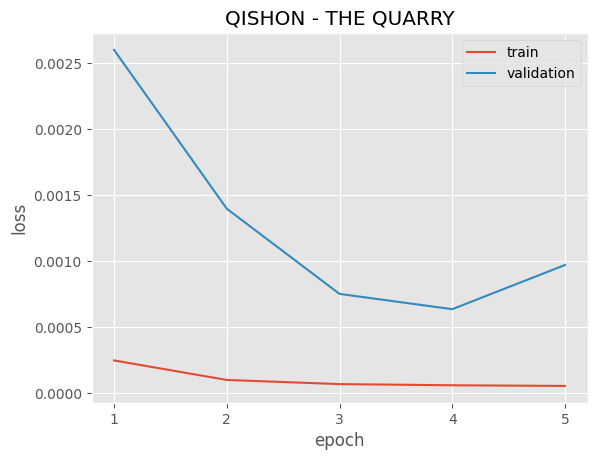

In [ ]:
plot_history(epochs, history, gauge_name)

258/258 [==============================] - 2s 5ms/step
Test NSE: 0.738
Test PersistentNSE: 0.693


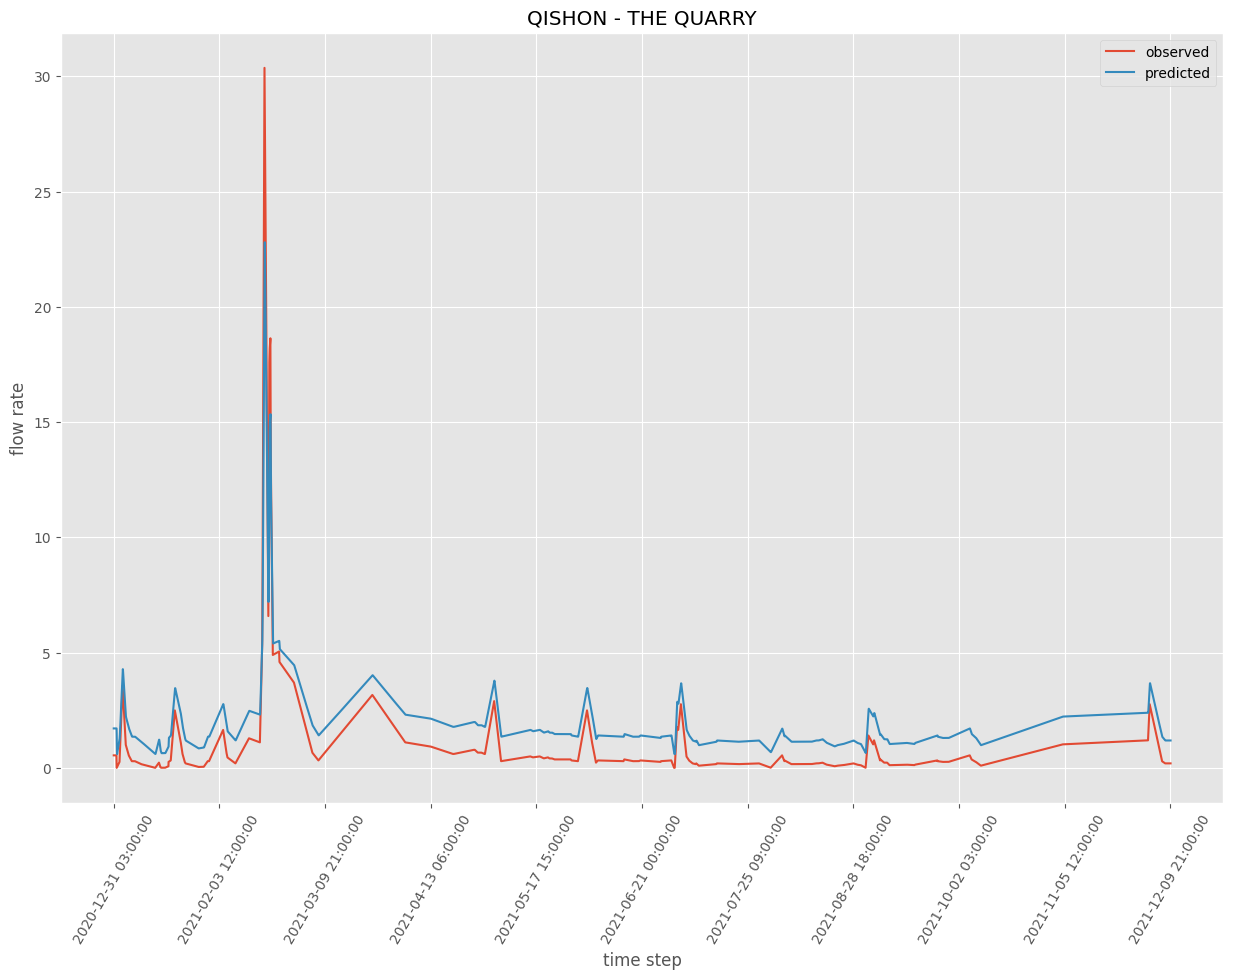

In [ ]:
time_test = list(gauge_df.reset_index(inplace=False).iloc[n_train_sequences+n_hours:, 0].astype('str'))
plot_predicted_vs_observed(model, scaler, test_X, test_y, n_hours, n_features, mean, time_test, gauge_name)

In [ ]:
persist_nse_without_precipitation = history.history['val_persistent_nse_tensor']

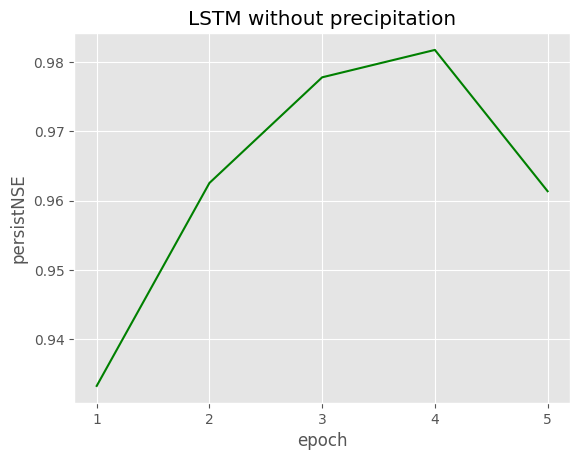

In [ ]:
plt.plot(persist_nse_without_precipitation, c='green')
plt.title('LSTM without precipitation')
plt.xticks(np.arange(epochs), np.arange(1, epochs+1))
plt.xlabel('epoch')
plt.ylabel('persistNSE')
plt.show()

## LSTM model with rainfall data

### Rainfall data from 3 closest rain stations

In [ ]:
ims_stations = [40523, 40526, 40619]

In [ ]:
dfs_stations = []
for i, ims_id in enumerate(ims_stations):

  dfs_rain = []
  for year in range(START_YEAR, END_YEAR+1):
    rain_path = f'/content/drive/MyDrive/FinalProjectDataScience/IMS/gauge_{gauge_id}/{year}/{ims_id}_.txt'
    df_rain = pd.read_csv(rain_path, delimiter=',')
    df_rain.rename(columns={'Date_Time[]': 'time', 'Rain[mm]': f'rain[mm]_ims_{i+1}'}, inplace=True)

    # impute -999.0 (null) values to zero
    df_rain[f'rain[mm]_ims_{i+1}'] = df_rain[f'rain[mm]_ims_{i+1}'].apply(lambda x: 0 if x == -999.0 else x)
    dfs_rain.append(df_rain)

  df_merged_rain = pd.concat(dfs_rain, ignore_index=True)
  df_merged_rain['time'] = pd.to_datetime(df_merged_rain['time'])
  dfs_stations.append(df_merged_rain)

In [ ]:
# time resolution of rain data is 10 minutes by default
if time_resolution != '10T':
  for i in range(len(dfs_stations)):
    dfs_stations[i] = resample_data(dfs_stations[i], time_resolution)
    dfs_stations[i].reset_index(inplace=True)

In [ ]:
gauge_df.reset_index(inplace=True)

In [ ]:
df_flow_rain_merged = gauge_df.copy(deep=True)
for df in dfs_stations:
  df_flow_rain_merged = pd.merge(df_flow_rain_merged, df, on='time')

In [ ]:
gauge_df.set_index('time', inplace=True)

In [ ]:
df_flow_rain_merged.set_index('time', inplace=True)

In [ ]:
df_flow_rain_merged

,flow,water_level,rain[mm]_ims_1,rain[mm]_ims_2,rain[mm]_ims_3
time,,,,,
2018-01-01 00:00:00,0.170000,10.400000,0.0,0.1,0.6
2018-01-01 01:00:00,0.238000,10.420000,0.0,0.0,1.5
2018-01-01 02:00:00,0.306000,10.440000,0.1,0.6,0.1
2018-01-01 03:00:00,0.374000,10.460000,0.8,0.4,0.1
2018-01-01 04:00:00,0.380051,10.461282,0.1,0.4,0.2
...,...,...,...,...,...
2021-12-09 18:00:00,0.202000,10.410000,0.0,0.0,0.0
2021-12-09 19:00:00,0.202000,10.410000,0.0,0.0,0.0
2021-12-09 20:00:00,0.202000,10.410000,0.0,0.0,0.0


### Training and Validation

In [ ]:
# number of lag hours
n_hours = l * sequences_per_hour
reframed, scaler = prepare_data(df_flow_rain_merged, n_hours)

# number of total features
n_features = len(df_flow_rain_merged.columns)

# drop columns of reframed that are not for prediction
n_cols_reframed = len(reframed.columns)
reframed.drop(reframed.columns[n_cols_reframed-n_features+1:], axis=1, inplace=True)

print(reframed.head())

# split into train and test sets
n_train_sequences = n_train_years * DAYS_PER_YEAR * HOURS_PER_DAY * sequences_per_hour
train_X, train_y, test_X, test_y = split_train_and_test(reframed, n_train_sequences, n_hours, n_features)

   var1(t-3)  var2(t-3)  var3(t-3)  var4(t-3)  var5(t-3)  var1(t-2)  \
3   0.000931   0.035813   0.000000   0.017857   0.130435   0.001322   
4   0.001322   0.041322   0.000000   0.000000   0.326087   0.001713   
5   0.001713   0.046832   0.011111   0.107143   0.021739   0.002104   
6   0.002104   0.052342   0.088889   0.071429   0.021739   0.002138   
7   0.002138   0.052695   0.011111   0.071429   0.043478   0.002173   

   var2(t-2)  var3(t-2)  var4(t-2)  var5(t-2)  var1(t-1)  var2(t-1)  \
3   0.041322   0.000000   0.000000   0.326087   0.001713   0.046832   
4   0.046832   0.011111   0.107143   0.021739   0.002104   0.052342   
5   0.052342   0.088889   0.071429   0.021739   0.002138   0.052695   
6   0.052695   0.011111   0.071429   0.043478   0.002173   0.053048   
7   0.053048   0.055556   0.053571   0.043478   0.002208   0.053401   

   var3(t-1)  var4(t-1)  var5(t-1)   var1(t)  
3   0.011111   0.107143   0.021739  0.002104  
4   0.088889   0.071429   0.021739  0.002138  
5   0

In [ ]:
# prepare creating model
metrics = [persistent_nse_tensor, nse_tensor]
create_model = build_model(train_X, nse_star, metrics, LSTM)

# run model
model = create_model()
history = model.fit(train_X, train_y, epochs=epochs, batch_size=batch_size, validation_split=validation_split, verbose=2, shuffle=False)

Epoch 1/5
274/274 - 4s - loss: 2.1148e-04 - persistent_nse_tensor: 0.9392 - nse_tensor: 0.9999 - val_loss: 0.0023 - val_persistent_nse_tensor: 0.9371 - val_nse_tensor: 0.9992 - 4s/epoch - 13ms/step
Epoch 2/5
274/274 - 1s - loss: 1.0250e-04 - persistent_nse_tensor: 0.9685 - nse_tensor: 1.0000 - val_loss: 0.0012 - val_persistent_nse_tensor: 0.9644 - val_nse_tensor: 0.9996 - 1s/epoch - 4ms/step
Epoch 3/5
274/274 - 1s - loss: 6.6190e-05 - persistent_nse_tensor: 0.9809 - nse_tensor: 1.0000 - val_loss: 7.9806e-04 - val_persistent_nse_tensor: 0.9768 - val_nse_tensor: 0.9997 - 1s/epoch - 4ms/step
Epoch 4/5
274/274 - 1s - loss: 4.7099e-05 - persistent_nse_tensor: 0.9874 - nse_tensor: 1.0000 - val_loss: 5.7145e-04 - val_persistent_nse_tensor: 0.9789 - val_nse_tensor: 0.9998 - 1s/epoch - 4ms/step
Epoch 5/5
274/274 - 1s - loss: 4.8275e-05 - persistent_nse_tensor: 0.9875 - nse_tensor: 1.0000 - val_loss: 7.1023e-04 - val_persistent_nse_tensor: 0.9765 - val_nse_tensor: 0.9998 - 1s/epoch - 4ms/step


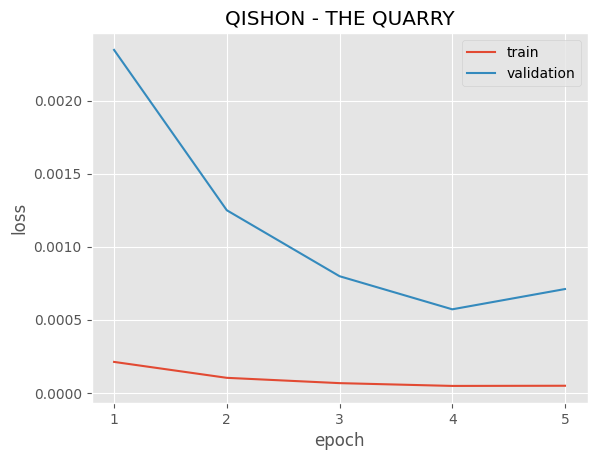

In [ ]:
plot_history(epochs, history, gauge_name)

258/258 [==============================] - 1s 2ms/step
Test NSE: 0.899
Test PersistentNSE: 0.881


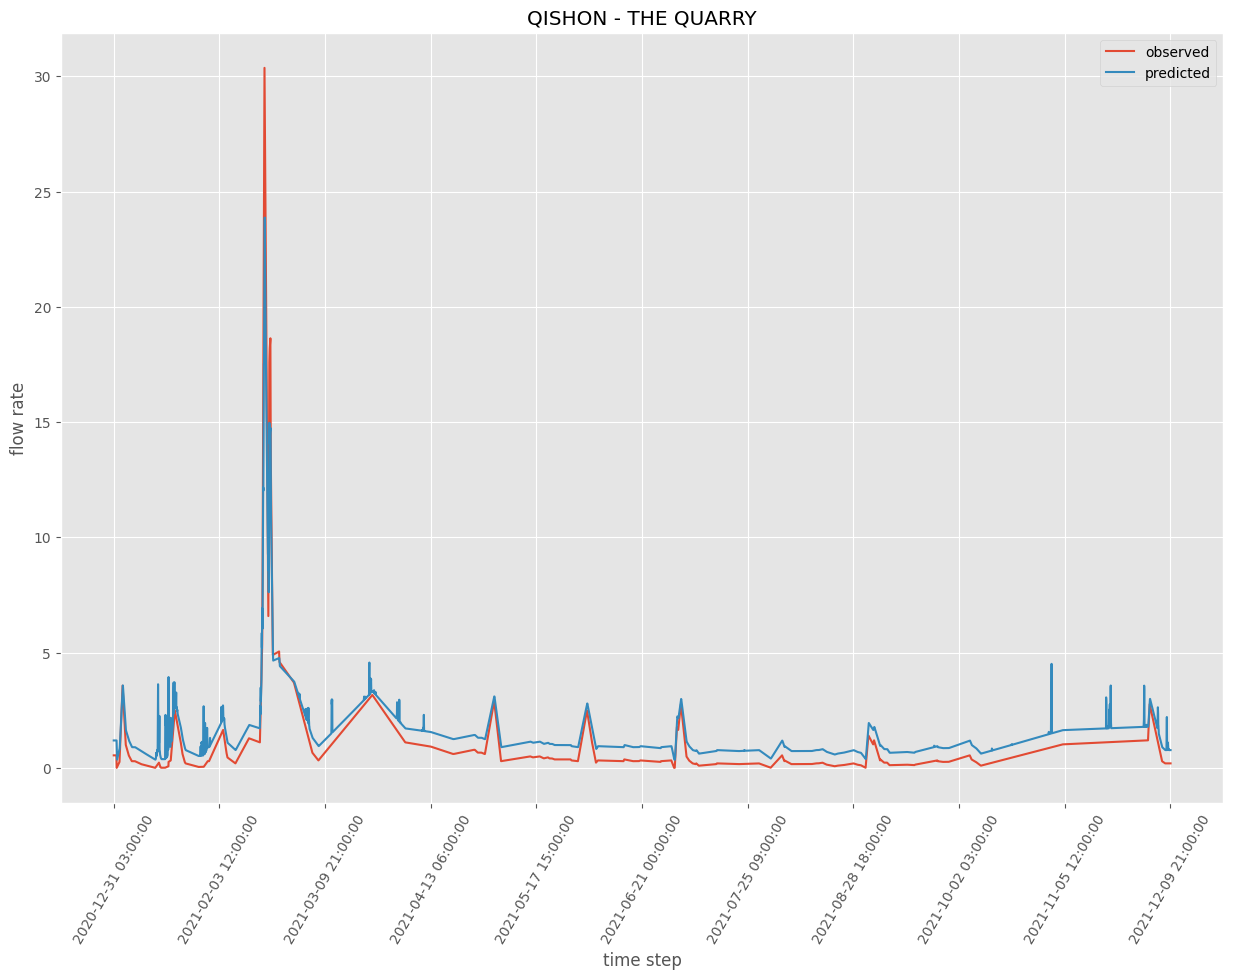

In [ ]:
time_test = list(df_flow_rain_merged.reset_index(inplace=False).iloc[n_train_sequences+n_hours:, 0].astype('str'))
plot_predicted_vs_observed(model, scaler, test_X, test_y, n_hours, n_features, mean, time_test, gauge_name)

In [ ]:
persist_nse_with_precipitation_lstm = history.history['val_persistent_nse_tensor']

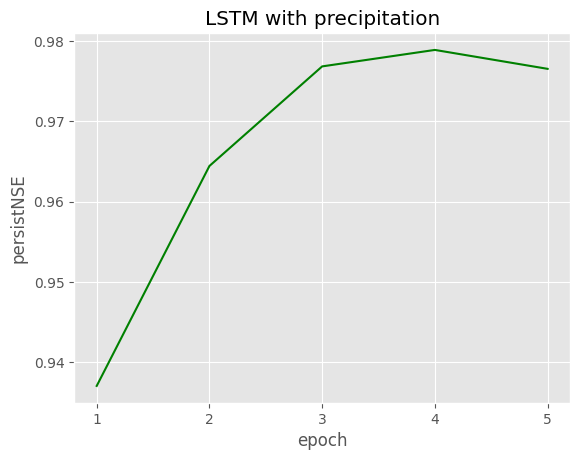

In [ ]:
plt.plot(persist_nse_with_precipitation_lstm, c='green')
plt.title('LSTM with precipitation')
plt.xticks(np.arange(epochs), np.arange(1, epochs+1))
plt.xlabel('epoch')
plt.ylabel('persistNSE')
plt.show()

### Hyperparameter Optimization

In [ ]:
model = KerasRegressor(build_fn=create_model, n_neurons=128)

In [ ]:
from keras.src.layers.serialization import activation
param_grid = dict(epochs=[5, 10, 15], batch_size=[32, 64, 128], n_neurons=[64, 128])
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=make_scorer(persistent_nse_numpy), n_jobs=-1, cv=3, verbose=2)
grid_result = grid.fit(train_X, train_y)
print("Done grid search")

Fitting 3 folds for each of 18 candidates, totalling 54 fits


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/15
411/411 [==============================] - 3s 3ms/step - loss: 7.4771e-04 - persistent_nse_tensor: 0.8418 - nse_tensor: 0.9998
Epoch 2/15
411/411 [==============================] - 1s 3ms/step - loss: 3.2419e-04 - persistent_nse_tensor: 0.9444 - nse_tensor: 0.9999
Epoch 3/15
411/411 [==============================] - 1s 3ms/step - loss: 2.8657e-04 - persistent_nse_tensor: 0.9478 - nse_tensor: 0.9999
Epoch 4/15
411/411 [==============================] - 1s 3ms/step - loss: 2.8645e-04 - persistent_nse_tensor: 0.9483 - nse_tensor: 0.9999
Epoch 5/15
411/411 [==============================] - 1s 3ms/step - loss: 3.4084e-04 - persistent_nse_tensor: 0.9451 - nse_tensor: 0.9999
Epoch 6/15
411/411 [==============================] - 1s 3ms/step - loss: 3.0718e-04 - persistent_nse_tensor: 0.9462 - nse_tensor: 0.9999
Epoch 7/15
411/411 [==============================] - 1s 3ms/step - loss: 2.8261e-04 - persistent_nse_tensor: 0.9509 - nse_tensor: 0.9999
Epoch 8/15
411/411 [==============

In [ ]:
print("Best: test score %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for m, s, param in zip(means, stds, params):
    print("mean test score %f (std test score %f) with: %r" % (m, s, param))

Best: test score 0.944448 using {'batch_size': 64, 'epochs': 15, 'n_neurons': 128}
mean test score 0.924441 (std test score 0.014709) with: {'batch_size': 32, 'epochs': 5, 'n_neurons': 64}
mean test score 0.852072 (std test score 0.132317) with: {'batch_size': 32, 'epochs': 5, 'n_neurons': 128}
mean test score 0.887007 (std test score 0.072114) with: {'batch_size': 32, 'epochs': 10, 'n_neurons': 64}
mean test score 0.887996 (std test score 0.053619) with: {'batch_size': 32, 'epochs': 10, 'n_neurons': 128}
mean test score 0.748543 (std test score 0.278968) with: {'batch_size': 32, 'epochs': 15, 'n_neurons': 64}
mean test score 0.929795 (std test score 0.036476) with: {'batch_size': 32, 'epochs': 15, 'n_neurons': 128}
mean test score 0.912812 (std test score 0.050761) with: {'batch_size': 64, 'epochs': 5, 'n_neurons': 64}
mean test score 0.903491 (std test score 0.024159) with: {'batch_size': 64, 'epochs': 5, 'n_neurons': 128}
mean test score 0.934149 (std test score 0.045454) with: {'ba

In [ ]:
def highlight_max_row(data):
    """Highlight the entire row if mean_test_score is the maximum."""
    max_score = data['mean_test_score'].max()
    highlight = ['background-color: yellow' if val == max_score else '' for val in data['mean_test_score']]
    return pd.DataFrame([highlight for _ in data.columns], index=data.columns).T

In [ ]:
df_grid = pd.DataFrame({
    'param_batch_size': grid_result.cv_results_['param_batch_size'].data,
    'param_epochs': grid_result.cv_results_['param_epochs'].data,
    'param_n_neurons': grid_result.cv_results_['param_n_neurons'].data,
    'mean_test_score': grid_result.cv_results_['mean_test_score']
})

df_grid.style.apply(highlight_max_row, axis=None)

,param_batch_size,param_epochs,param_n_neurons,mean_test_score
0,32,5,64,0.924441
1,32,5,128,0.852072
2,32,10,64,0.887007
3,32,10,128,0.887996
4,32,15,64,0.748543
5,32,15,128,0.929795
6,64,5,64,0.912812
7,64,5,128,0.903491
8,64,10,64,0.934149
9,64,10,128,0.912057


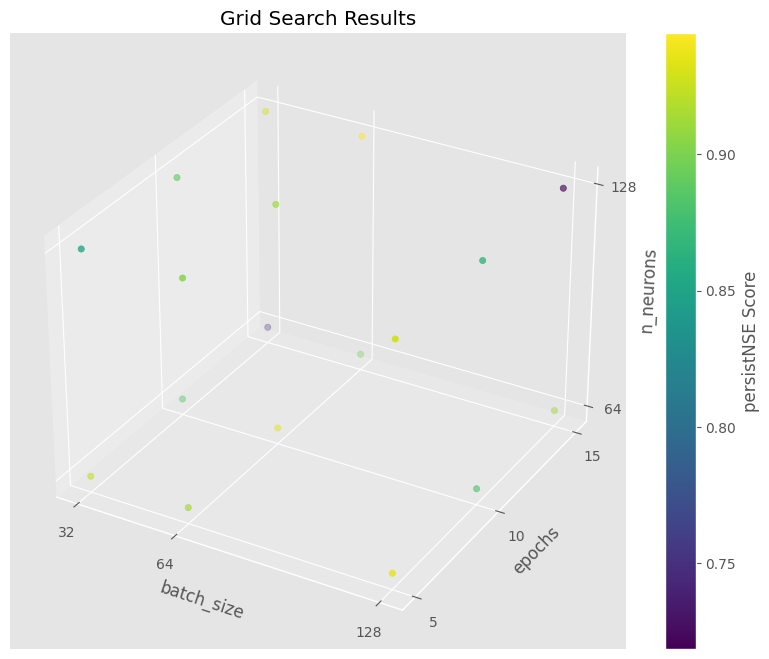

In [ ]:
import plotly.graph_objs as go
# Create a meshgrid for the three parameters
param_batch_size = grid_result.cv_results_['param_batch_size'].data
param_epochs = grid_result.cv_results_['param_epochs'].data
param_n_neurons = grid_result.cv_results_['param_n_neurons'].data
performance_scores = grid_result.cv_results_['mean_test_score']
# param1, param2, param3 = np.meshgrid(param_batch_size, param_epochs, param_n_neurons)
param1, param2, param3 = param_batch_size, param_epochs, param_n_neurons

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot with color representing performance
scatter = ax.scatter(param1, param2, param3, c=performance_scores, cmap='viridis')
fig.colorbar(scatter, label='persistNSE Score')

# Set labels and title
ax.set_xlabel('batch_size')
ax.set_xticks([32, 64, 128])
ax.set_ylabel('epochs')
ax.set_yticks([5, 10, 15])
ax.set_zlabel('n_neurons')
ax.set_zticks([64, 128])
ax.set_title('Grid Search Results')

# Show the plot
plt.show()

### Running Model After Hyperparameter Optimization

In [ ]:
# Best hyperparameters
epochs_best_lstm = 15
n_neurons_best_lstm = 128
batch_size_best_lstm = 64

In [ ]:
# number of lag hours
n_hours = l * sequences_per_hour
reframed, scaler = prepare_data(df_flow_rain_merged, n_hours)

# number of total features
n_features = len(df_flow_rain_merged.columns)

# drop columns of reframed that are not for prediction
n_cols_reframed = len(reframed.columns)
reframed.drop(reframed.columns[n_cols_reframed-n_features+1:], axis=1, inplace=True)

# split into train and test sets
n_train_sequences = n_train_years * DAYS_PER_YEAR * HOURS_PER_DAY * sequences_per_hour
train_X, train_y, test_X, test_y = split_train_and_test(reframed, n_train_sequences, n_hours, n_features)

In [ ]:
# prepare creating model
metrics = [persistent_nse_tensor, nse_tensor]
create_model = build_model(train_X, nse_star, metrics, LSTM)

model = create_model(n_neurons_best_lstm)
history = model.fit(train_X, train_y, epochs=epochs_best_lstm, batch_size=batch_size_best_lstm, validation_split=validation_split, verbose=2, shuffle=False)

Epoch 1/15
274/274 - 4s - loss: 2.3911e-04 - persistent_nse_tensor: 0.9371 - nse_tensor: 0.9999 - val_loss: 0.0028 - val_persistent_nse_tensor: 0.9255 - val_nse_tensor: 0.9991 - 4s/epoch - 13ms/step
Epoch 2/15
274/274 - 1s - loss: 1.1062e-04 - persistent_nse_tensor: 0.9675 - nse_tensor: 1.0000 - val_loss: 0.0015 - val_persistent_nse_tensor: 0.9599 - val_nse_tensor: 0.9995 - 1s/epoch - 4ms/step
Epoch 3/15
274/274 - 1s - loss: 7.1311e-05 - persistent_nse_tensor: 0.9794 - nse_tensor: 1.0000 - val_loss: 8.5743e-04 - val_persistent_nse_tensor: 0.9755 - val_nse_tensor: 0.9997 - 1s/epoch - 4ms/step
Epoch 4/15
274/274 - 1s - loss: 5.0048e-05 - persistent_nse_tensor: 0.9864 - nse_tensor: 1.0000 - val_loss: 5.7724e-04 - val_persistent_nse_tensor: 0.9809 - val_nse_tensor: 0.9998 - 1s/epoch - 4ms/step
Epoch 5/15
274/274 - 1s - loss: 4.9967e-05 - persistent_nse_tensor: 0.9869 - nse_tensor: 1.0000 - val_loss: 6.9710e-04 - val_persistent_nse_tensor: 0.9791 - val_nse_tensor: 0.9998 - 1s/epoch - 4ms/st

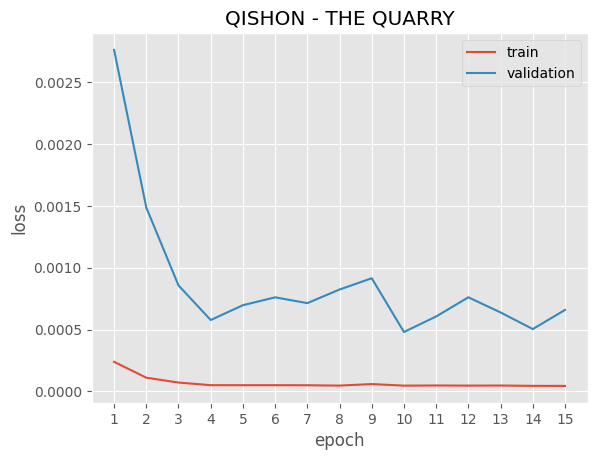

In [ ]:
plot_history(epochs_best_lstm, history, gauge_name)

258/258 [==============================] - 1s 2ms/step
Test NSE: 0.919
Test PersistentNSE: 0.905


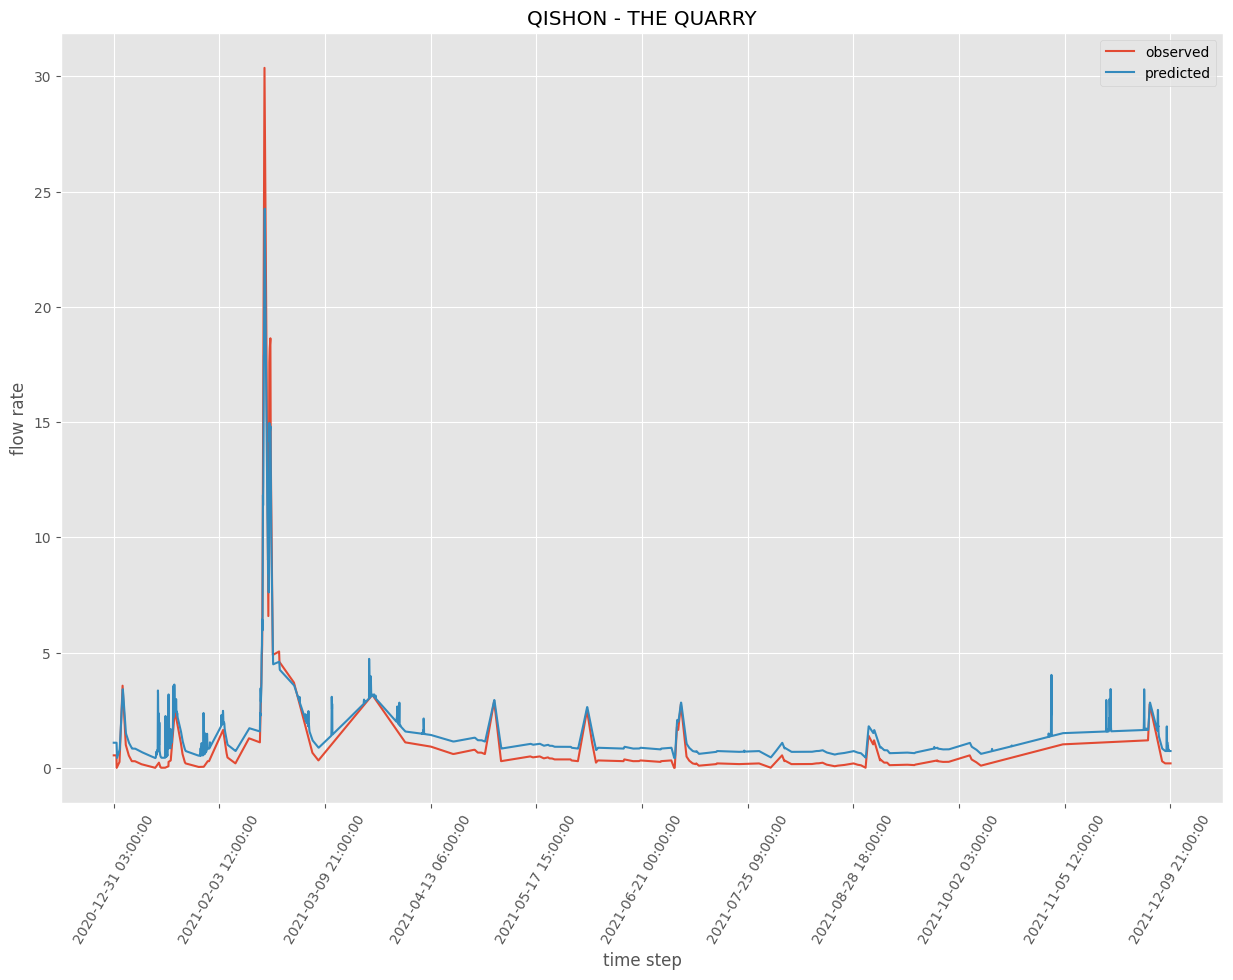

In [ ]:
time_test = list(df_flow_rain_merged.reset_index(inplace=False).iloc[n_train_sequences+n_hours:, 0].astype('str'))
plot_predicted_vs_observed(model, scaler, test_X, test_y, n_hours, n_features, mean, time_test, gauge_name)

In [ ]:
persist_nse_with_precipitation_opt_lstm = history.history['val_persistent_nse_tensor']

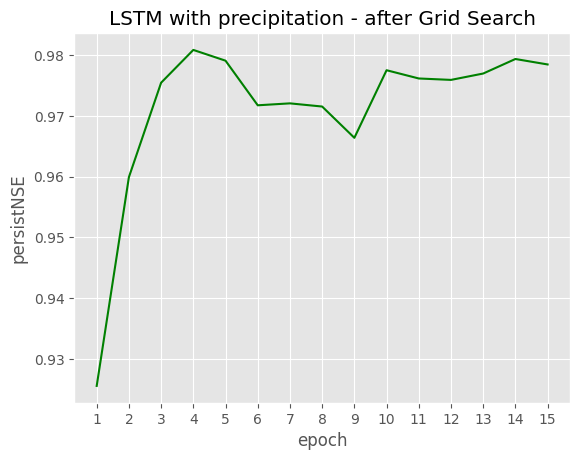

In [ ]:
plt.plot(persist_nse_with_precipitation_opt_lstm, c='green')
plt.title('LSTM with precipitation - after Grid Search')
plt.xticks(np.arange(epochs_best_lstm), np.arange(1, epochs_best_lstm+1))
plt.xlabel('epoch')
plt.ylabel('persistNSE')
plt.show()

## GRU model with rainfall data

### Training and Validation

In [ ]:
# number of lag hours
n_hours = l * sequences_per_hour
reframed, scaler = prepare_data(df_flow_rain_merged, n_hours)

# number of total features
n_features = len(df_flow_rain_merged.columns)

# drop columns of reframed that are not for prediction
n_cols_reframed = len(reframed.columns)
reframed.drop(reframed.columns[n_cols_reframed-n_features+1:], axis=1, inplace=True)

print(reframed.head())

# split into train and test sets
n_train_sequences = n_train_years * DAYS_PER_YEAR * HOURS_PER_DAY * sequences_per_hour
train_X, train_y, test_X, test_y = split_train_and_test(reframed, n_train_sequences, n_hours, n_features)

   var1(t-3)  var2(t-3)  var3(t-3)  var4(t-3)  var5(t-3)  var1(t-2)  \
3   0.000931   0.035813   0.000000   0.017857   0.130435   0.001322   
4   0.001322   0.041322   0.000000   0.000000   0.326087   0.001713   
5   0.001713   0.046832   0.011111   0.107143   0.021739   0.002104   
6   0.002104   0.052342   0.088889   0.071429   0.021739   0.002138   
7   0.002138   0.052695   0.011111   0.071429   0.043478   0.002173   

   var2(t-2)  var3(t-2)  var4(t-2)  var5(t-2)  var1(t-1)  var2(t-1)  \
3   0.041322   0.000000   0.000000   0.326087   0.001713   0.046832   
4   0.046832   0.011111   0.107143   0.021739   0.002104   0.052342   
5   0.052342   0.088889   0.071429   0.021739   0.002138   0.052695   
6   0.052695   0.011111   0.071429   0.043478   0.002173   0.053048   
7   0.053048   0.055556   0.053571   0.043478   0.002208   0.053401   

   var3(t-1)  var4(t-1)  var5(t-1)   var1(t)  
3   0.011111   0.107143   0.021739  0.002104  
4   0.088889   0.071429   0.021739  0.002138  
5   0

In [ ]:
# prepare creating model
metrics = [persistent_nse_tensor, nse_tensor]
create_model = build_model(train_X, nse_star, metrics, GRU)

# run model
model = create_model()
history = model.fit(train_X, train_y, epochs=epochs, batch_size=batch_size, validation_split=validation_split, verbose=2, shuffle=False)

Epoch 1/5
274/274 - 3s - loss: 1.9688e-04 - persistent_nse_tensor: 0.9303 - nse_tensor: 1.0000 - val_loss: 0.0015 - val_persistent_nse_tensor: 0.9555 - val_nse_tensor: 0.9995 - 3s/epoch - 12ms/step
Epoch 2/5
274/274 - 1s - loss: 8.5025e-05 - persistent_nse_tensor: 0.9735 - nse_tensor: 1.0000 - val_loss: 0.0010 - val_persistent_nse_tensor: 0.9451 - val_nse_tensor: 0.9997 - 1s/epoch - 4ms/step
Epoch 3/5
274/274 - 1s - loss: 5.9140e-05 - persistent_nse_tensor: 0.9831 - nse_tensor: 1.0000 - val_loss: 0.0010 - val_persistent_nse_tensor: 0.9471 - val_nse_tensor: 0.9997 - 1s/epoch - 4ms/step
Epoch 4/5
274/274 - 1s - loss: 4.7125e-05 - persistent_nse_tensor: 0.9867 - nse_tensor: 1.0000 - val_loss: 6.8589e-04 - val_persistent_nse_tensor: 0.9604 - val_nse_tensor: 0.9998 - 1s/epoch - 4ms/step
Epoch 5/5
274/274 - 1s - loss: 4.9659e-05 - persistent_nse_tensor: 0.9864 - nse_tensor: 1.0000 - val_loss: 8.5653e-04 - val_persistent_nse_tensor: 0.9567 - val_nse_tensor: 0.9997 - 1s/epoch - 4ms/step


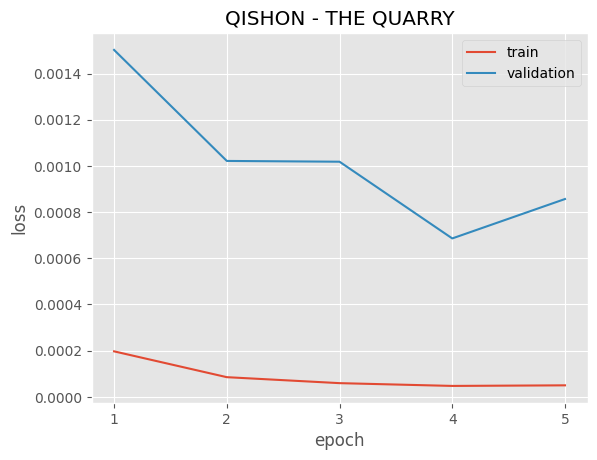

In [ ]:
plot_history(epochs, history, gauge_name)

258/258 [==============================] - 1s 2ms/step
Test NSE: 0.654
Test PersistentNSE: 0.595


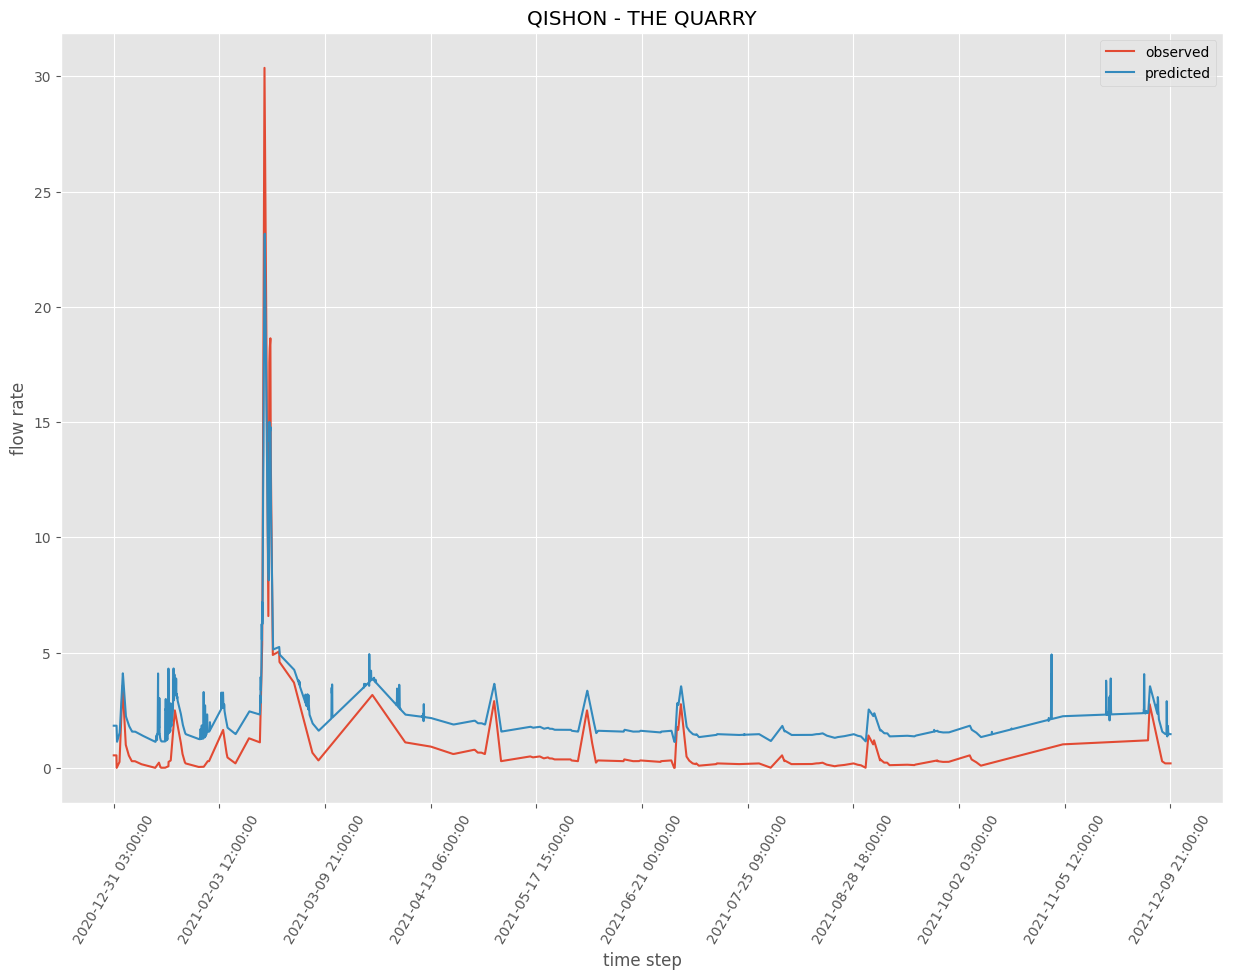

In [ ]:
time_test = list(df_flow_rain_merged.reset_index(inplace=False).iloc[n_train_sequences+n_hours:, 0].astype('str'))
plot_predicted_vs_observed(model, scaler, test_X, test_y, n_hours, n_features, mean, time_test, gauge_name)

In [ ]:
persist_nse_with_precipitation_gru = history.history['val_persistent_nse_tensor']

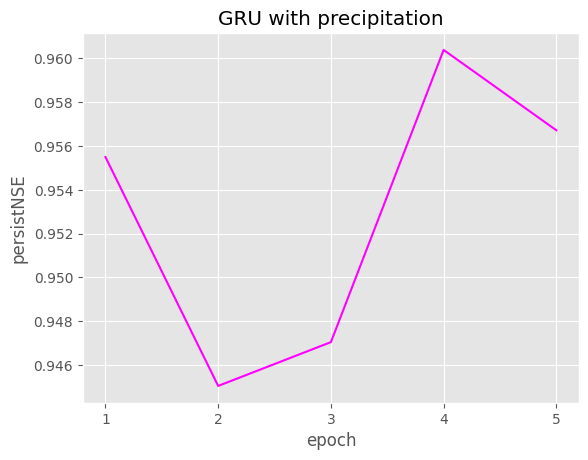

In [ ]:
plt.plot(persist_nse_with_precipitation_gru, c='magenta')
plt.title('GRU with precipitation')
plt.xticks(np.arange(epochs), np.arange(1, epochs+1))
plt.xlabel('epoch')
plt.ylabel('persistNSE')
plt.show()

### Hyperparameter Optimization

In [ ]:
model = KerasRegressor(build_fn=create_model, n_neurons=128)

In [ ]:
from keras.src.layers.serialization import activation
param_grid = dict(epochs=[5, 10, 15], batch_size=[32, 64, 128], n_neurons=[64, 128])
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=make_scorer(persistent_nse_numpy), n_jobs=-1, cv=3, verbose=2)
grid_result = grid.fit(train_X, train_y)
print("Done grid search")

Fitting 3 folds for each of 18 candidates, totalling 54 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/15
411/411 [==============================] - 3s 3ms/step - loss: 5.1561e-04 - persistent_nse_tensor: 0.8826 - nse_tensor: 0.9999
Epoch 2/15
411/411 [==============================] - 1s 3ms/step - loss: 3.3508e-04 - persistent_nse_tensor: 0.9396 - nse_tensor: 0.9999
Epoch 3/15
411/411 [==============================] - 1s 3ms/step - loss: 2.8194e-04 - persistent_nse_tensor: 0.9466 - nse_tensor: 0.9999
Epoch 4/15
411/411 [==============================] - 1s 3ms/step - loss: 2.9577e-04 - persistent_nse_tensor: 0.9405 - nse_tensor: 0.9999
Epoch 5/15
411/411 [==============================] - 1s 3ms/step - loss: 3.3464e-04 - persistent_nse_tensor: 0.9424 - nse_tensor: 0.9999
Epoch 6/15
411/411 [==============================] - 1s 3ms/step - loss: 2.8121e-04 - persistent_nse_tensor: 0.9476 - nse_tensor: 0.9999
Epoch 7/15
411/411 [==============================] - 1s 3ms/step - loss: 2.4546e-04 - persistent_nse_tensor: 0.9522 - nse_tensor: 0.9999
Epoch 8/15
411/411 [==============

In [ ]:
print("Best: test score %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for m, s, param in zip(means, stds, params):
    print("mean test score %f (std test score %f) with: %r" % (m, s, param))

Best: test score 0.950700 using {'batch_size': 64, 'epochs': 15, 'n_neurons': 128}
mean test score -0.083647 (std test score 1.232533) with: {'batch_size': 32, 'epochs': 5, 'n_neurons': 64}
mean test score 0.703900 (std test score 0.359901) with: {'batch_size': 32, 'epochs': 5, 'n_neurons': 128}
mean test score 0.816539 (std test score 0.142314) with: {'batch_size': 32, 'epochs': 10, 'n_neurons': 64}
mean test score 0.832289 (std test score 0.135260) with: {'batch_size': 32, 'epochs': 10, 'n_neurons': 128}
mean test score 0.860754 (std test score 0.050755) with: {'batch_size': 32, 'epochs': 15, 'n_neurons': 64}
mean test score 0.861033 (std test score 0.108559) with: {'batch_size': 32, 'epochs': 15, 'n_neurons': 128}
mean test score 0.912083 (std test score 0.052066) with: {'batch_size': 64, 'epochs': 5, 'n_neurons': 64}
mean test score 0.816967 (std test score 0.084455) with: {'batch_size': 64, 'epochs': 5, 'n_neurons': 128}
mean test score 0.719816 (std test score 0.296656) with: {'b

In [ ]:
df_grid = pd.DataFrame({
    'param_batch_size': grid_result.cv_results_['param_batch_size'].data,
    'param_epochs': grid_result.cv_results_['param_epochs'].data,
    'param_n_neurons': grid_result.cv_results_['param_n_neurons'].data,
    'mean_test_score': grid_result.cv_results_['mean_test_score']
})

df_grid.style.apply(highlight_max_row, axis=None)

,param_batch_size,param_epochs,param_n_neurons,mean_test_score
0,32,5,64,-0.083647
1,32,5,128,0.703900
2,32,10,64,0.816539
3,32,10,128,0.832289
4,32,15,64,0.860754
5,32,15,128,0.861033
6,64,5,64,0.912083
7,64,5,128,0.816967
8,64,10,64,0.719816
9,64,10,128,0.945306


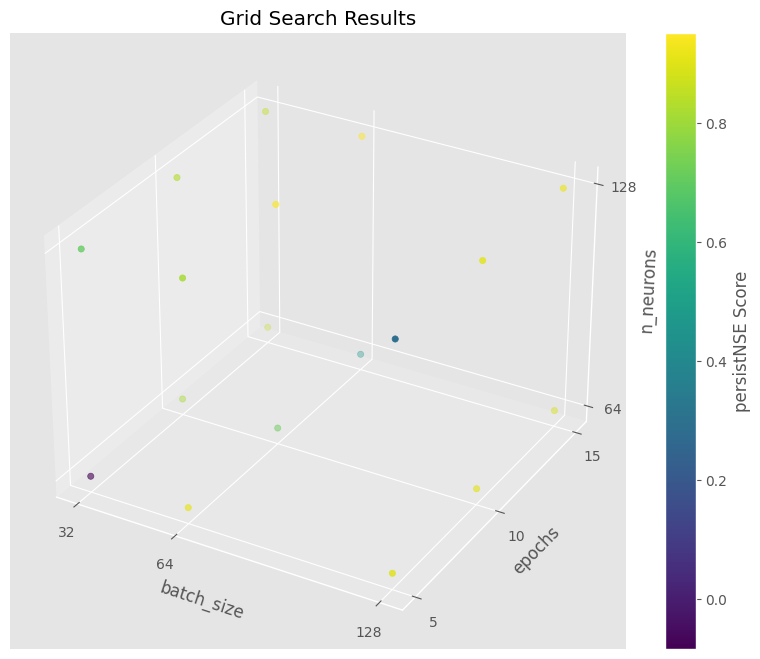

In [ ]:
import plotly.graph_objs as go
# Create a meshgrid for the three parameters
param_batch_size = grid_result.cv_results_['param_batch_size'].data
param_epochs = grid_result.cv_results_['param_epochs'].data
param_n_neurons = grid_result.cv_results_['param_n_neurons'].data
performance_scores = grid_result.cv_results_['mean_test_score']
# param1, param2, param3 = np.meshgrid(param_batch_size, param_epochs, param_n_neurons)
param1, param2, param3 = param_batch_size, param_epochs, param_n_neurons

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot with color representing performance
scatter = ax.scatter(param1, param2, param3, c=performance_scores, cmap='viridis')
fig.colorbar(scatter, label='persistNSE Score')

# Set labels and title
ax.set_xlabel('batch_size')
ax.set_xticks([32, 64, 128])
ax.set_ylabel('epochs')
ax.set_yticks([5, 10, 15])
ax.set_zlabel('n_neurons')
ax.set_zticks([64, 128])
ax.set_title('Grid Search Results')

# Show the plot
plt.show()

### Running Model After Hyperparameter Optimization

In [ ]:
# Best hyperparameters
epochs_best_gru = 15
n_neurons_best_gru = 128
batch_size_best_gru = 64

In [ ]:
# number of lag hours
n_hours = l * sequences_per_hour
reframed, scaler = prepare_data(df_flow_rain_merged, n_hours)

# number of total features
n_features = len(df_flow_rain_merged.columns)

# drop columns of reframed that are not for prediction
n_cols_reframed = len(reframed.columns)
reframed.drop(reframed.columns[n_cols_reframed-n_features+1:], axis=1, inplace=True)

# split into train and test sets
n_train_sequences = n_train_years * DAYS_PER_YEAR * HOURS_PER_DAY * sequences_per_hour
train_X, train_y, test_X, test_y = split_train_and_test(reframed, n_train_sequences, n_hours, n_features)

In [ ]:
# prepare creating model
metrics = [persistent_nse_tensor, nse_tensor]
create_model = build_model(train_X, nse_star, metrics, GRU)

model = create_model(n_neurons_best_gru)
history = model.fit(train_X, train_y, epochs=epochs_best_gru, batch_size=batch_size_best_gru, validation_split=validation_split, verbose=2, shuffle=False)

Epoch 1/15
274/274 - 4s - loss: 1.8682e-04 - persistent_nse_tensor: 0.9373 - nse_tensor: 1.0000 - val_loss: 0.0015 - val_persistent_nse_tensor: 0.9527 - val_nse_tensor: 0.9995 - 4s/epoch - 14ms/step
Epoch 2/15
274/274 - 1s - loss: 8.4556e-05 - persistent_nse_tensor: 0.9737 - nse_tensor: 1.0000 - val_loss: 0.0011 - val_persistent_nse_tensor: 0.9347 - val_nse_tensor: 0.9996 - 1s/epoch - 4ms/step
Epoch 3/15
274/274 - 1s - loss: 6.0567e-05 - persistent_nse_tensor: 0.9825 - nse_tensor: 1.0000 - val_loss: 0.0011 - val_persistent_nse_tensor: 0.9424 - val_nse_tensor: 0.9996 - 1s/epoch - 4ms/step
Epoch 4/15
274/274 - 1s - loss: 4.7522e-05 - persistent_nse_tensor: 0.9865 - nse_tensor: 1.0000 - val_loss: 7.1750e-04 - val_persistent_nse_tensor: 0.9565 - val_nse_tensor: 0.9998 - 1s/epoch - 4ms/step
Epoch 5/15
274/274 - 1s - loss: 4.9806e-05 - persistent_nse_tensor: 0.9863 - nse_tensor: 1.0000 - val_loss: 8.6562e-04 - val_persistent_nse_tensor: 0.9548 - val_nse_tensor: 0.9997 - 1s/epoch - 4ms/step
E

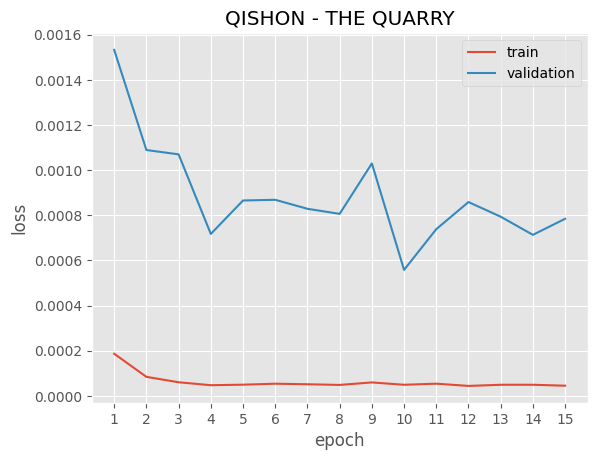

In [ ]:
plot_history(epochs_best_gru, history, gauge_name)

258/258 [==============================] - 1s 2ms/step
Test NSE: 0.769
Test PersistentNSE: 0.730


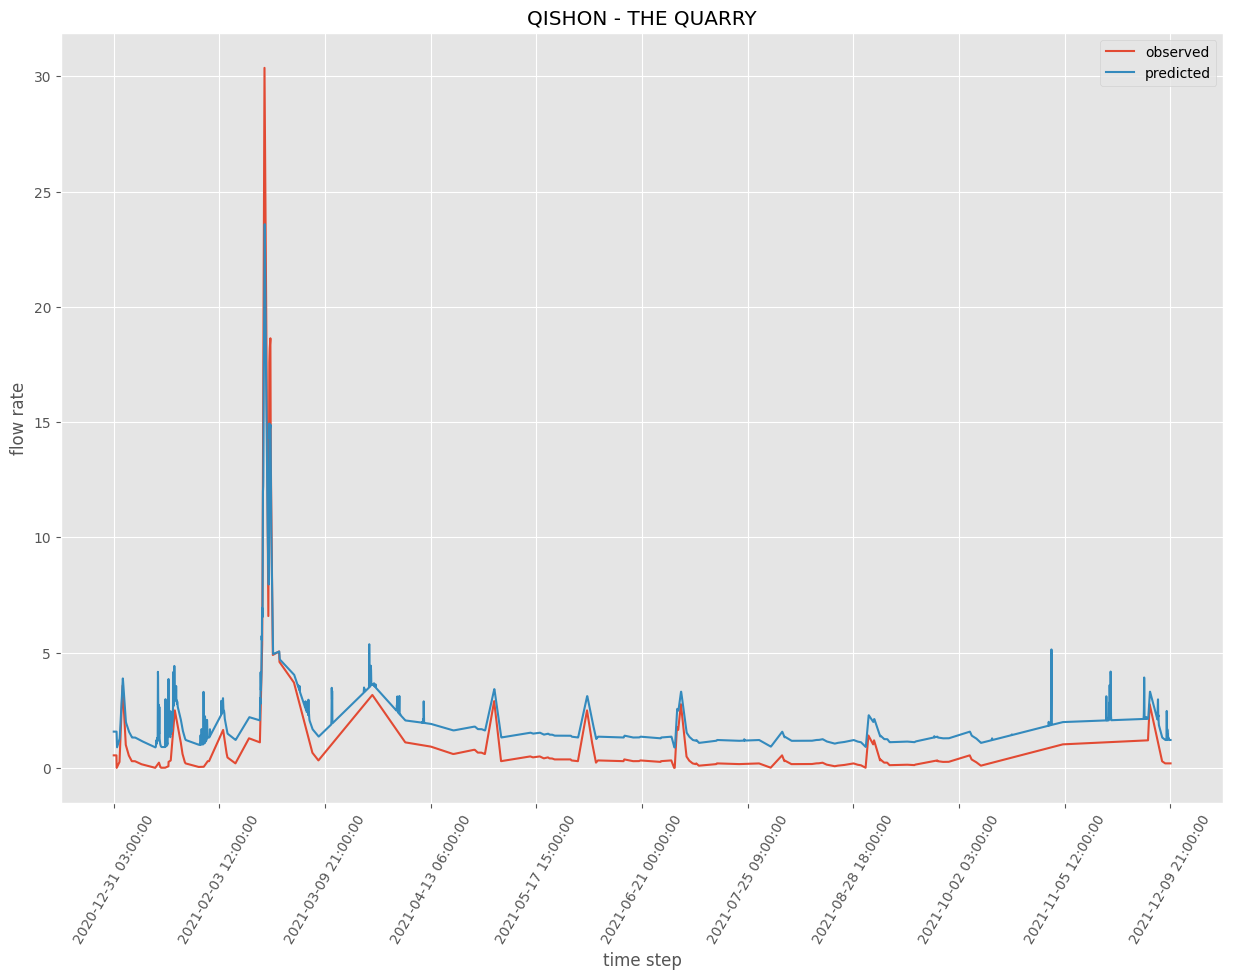

In [ ]:
time_test = list(df_flow_rain_merged.reset_index(inplace=False).iloc[n_train_sequences+n_hours:, 0].astype('str'))
plot_predicted_vs_observed(model, scaler, test_X, test_y, n_hours, n_features, mean, time_test, gauge_name)

In [ ]:
persist_nse_with_precipitation_opt_gru = history.history['val_persistent_nse_tensor']

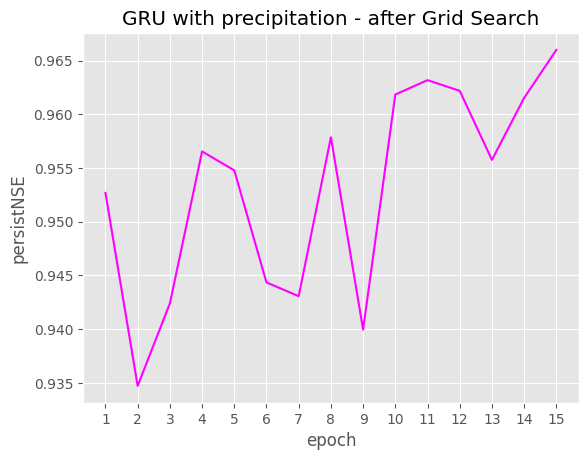

In [ ]:
plt.plot(persist_nse_with_precipitation_opt_gru, c='magenta')
plt.title('GRU with precipitation - after Grid Search')
plt.xticks(np.arange(epochs_best_gru), np.arange(1, epochs_best_gru+1))
plt.xlabel('epoch')
plt.ylabel('persistNSE')
plt.show()

## LSTM VS GRU

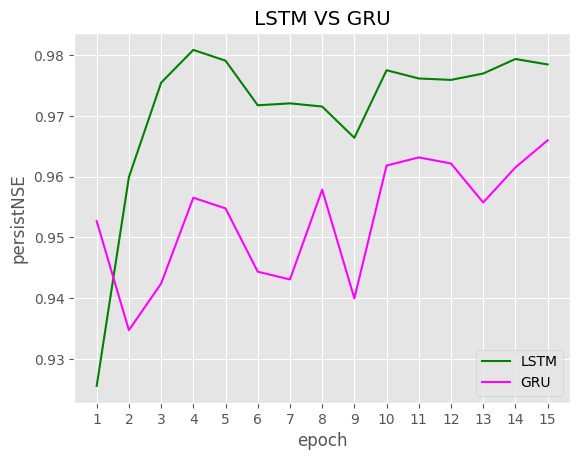

In [ ]:
plt.plot(persist_nse_with_precipitation_opt_lstm, label='LSTM', c='green')
plt.plot(persist_nse_with_precipitation_opt_gru, label='GRU', c='magenta')
plt.title('LSTM VS GRU')
epochs_max = max(epochs_best_lstm, epochs_best_gru)
plt.xticks(np.arange(epochs_max), np.arange(1, epochs_max + 1))
plt.xlabel('epoch')
plt.ylabel('persistNSE')
plt.legend()
plt.show()